In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle


#import plotly.graph_objects as go


In [7]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

# Data load and transform

In [8]:
train_df = pd.read_csv("../data/training_data/train_final.csv", index_col = 0)

In [9]:
train_df.drop(columns = ['game_id'], inplace = True)
train_df = train_df.astype(dtype={x:np.float16 for x in train_df.columns[:-1]})

In [10]:
train_df.loc[:,['H_GK', 'H_attack', 'H_defense', 'H_midfield','A_GK', 'A_attack', 'A_defense', 'A_midfield' ]]=\
train_df.loc[:,['H_GK', 'H_attack', 'H_defense', 'H_midfield','A_GK', 'A_attack', 'A_defense', 'A_midfield' ]]/5



In [11]:
col_select = ['H_GK', 'H_attack', 'H_defense', 'H_midfield','A_GK', 'A_attack', 'A_defense', 'A_midfield','Home_result' ]
col_mask = [x  for x in train_df.columns if (x not in col_select)]
train_df.loc[:,col_mask]=train_df.loc[:,col_mask]/100



In [12]:
#Remplace la différence de but par 0:HomeWin, 1: Draw, 2: AwayWin
train_df.Home_result=train_df.Home_result.apply(lambda x: np.int8(0) if x>0 else (np.int8(2) if x<0 else np.int8(1)))

In [13]:
X = train_df.loc[:,train_df.columns[:-1]]
y = train_df.Home_result

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=0, stratify=y)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
train_batch = train.shuffle(len(y_train)).batch(20)
val_batch = test.shuffle(len(y_test)).batch(20)

# Fully Connected Neural Network + Dropout

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import *
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.models import Sequential

In [ ]:
X_train.shape

(22158, 174)

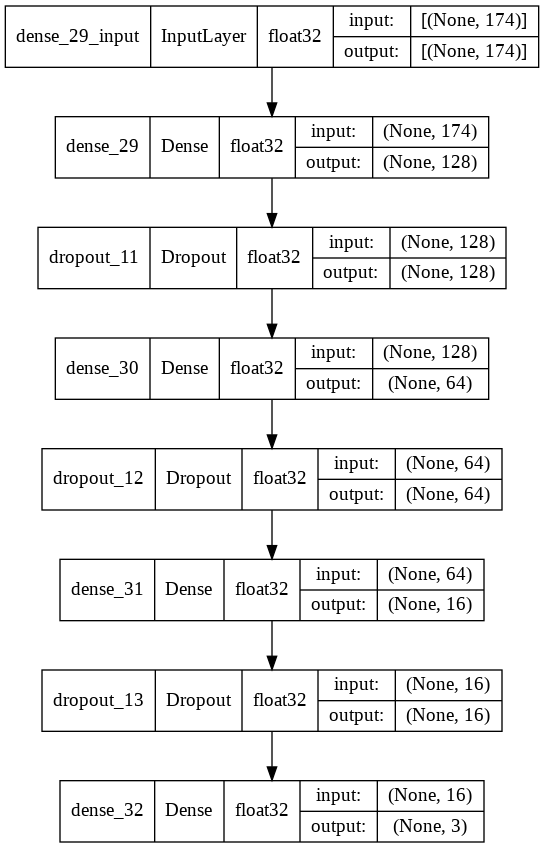

In [ ]:
sequential_model = Sequential()
sequential_model.add(Dense(128,'relu', input_shape = [174]))
sequential_model.add(Dropout(.25))
sequential_model.add(Dense(64,'relu'))
sequential_model.add(Dropout(.25))
sequential_model.add(Dense(16,'relu'))
sequential_model.add(Dropout(.25))
sequential_model.add(Dense(3,'softmax'))
tf.keras.utils.plot_model(
    sequential_model,
    show_shapes=True, 
    show_dtype=True
)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam(0.0001)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
sequential_model.compile(optimizer=opt, loss=loss, metrics = [metric])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
history = sequential_model.fit(train_batch, epochs=30, validation_data=val_batch, callbacks=[tensorboard_callback])

Epoch 1/30
1108/1108 [==============================] - 4s 3ms/step - loss: 1.0789 - sparse_categorical_accuracy: 0.4339 - val_loss: 1.0638 - val_sparse_categorical_accuracy: 0.4493
Epoch 2/30
1108/1108 [==============================] - 3s 2ms/step - loss: 1.0567 - sparse_categorical_accuracy: 0.4584 - val_loss: 1.0395 - val_sparse_categorical_accuracy: 0.5037
Epoch 3/30
1108/1108 [==============================] - 3s 3ms/step - loss: 1.0386 - sparse_categorical_accuracy: 0.4822 - val_loss: 1.0168 - val_sparse_categorical_accuracy: 0.5117
Epoch 4/30
1108/1108 [==============================] - 3s 3ms/step - loss: 1.0261 - sparse_categorical_accuracy: 0.4965 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.5078
Epoch 5/30
1108/1108 [==============================] - 3s 3ms/step - loss: 1.0182 - sparse_categorical_accuracy: 0.5050 - val_loss: 1.0058 - val_sparse_categorical_accuracy: 0.5124
Epoch 6/30
1108/1108 [==============================] - 3s 3ms/step - loss: 1.0162 - spars

In [ ]:
#%tensorboard --logdir logs

In [ ]:
X_test.loc[0,:]

H_GK                                1.00000
H_GK_overall                       70.00000
H_GK_potential                     70.00000
H_GK_attacking_crossing            25.00000
H_GK_attacking_heading_accuracy    25.00000
                                     ...   
A_MF_power_stamina                 78.81250
A_MF_mentality_aggression          59.28125
A_MF_mentality_positioning         74.75000
A_MF_mentality_penalties           67.12500
A_MF_mentality_composure            0.00000
Name: 0, Length: 174, dtype: float16

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["sparse_categorical_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_sparse_categorical_accuracy"],
                          name="Validation accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])

fig.update_layout(
    title="training and val accuracy across epochs",
    xaxis_title="epochs",
    yaxis_title="Cross entropy"
    )

fig.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])

fig.update_layout(
    title="training and val accuracy across epochs",
    xaxis_title="epochs",
    yaxis_title="Cross entropy"
    )

fig.show()

In [ ]:
sequential_model.save('/content/drive/MyDrive/Colab Notebooks/FootProphet/Model/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/FootProphet/Model/my_model/assets


In [ ]:
sequential_model.predict(X_test.loc[X_test.index[3],:].values.reshape(1,-1))

array([[0.30569917, 0.26155075, 0.4327501 ]], dtype=float32)

In [ ]:
X_test.loc[0,:].values.reshape(1,-1)

(1, 174)

In [ ]:
y_test[y_test.index[3]]

2

In [47]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/FootProphet/Model/my_model')

In [55]:
X.values.shape

(29545, 174)

In [48]:
x_pred = model.predict(X)

In [49]:
X_pred = [int(np.argwhere(y == y.max()).squeeze())  for y in x_pred]


accuracy:  0.5238449822304958
Recall: 
 {0: 0.8614480524372787, 1: 0.0, 2: 0.4454114795637325} 
Precision: 
 {0: 0.524351096028616, 1: nan, 2: 0.5224189171727613} 
F1-score: 
 {0: 0.6518999971492916, 1: nan, 2: 0.4808515699333968}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in double_scalars



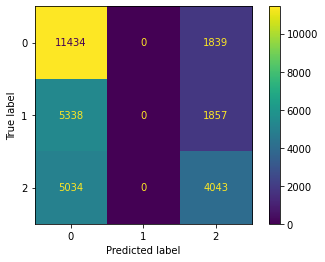

In [54]:
cm_metrics(y,X_pred,[0,1,2])

# MLP Classifier

In [15]:
from sklearn.neural_network import MLPClassifier

In [21]:
MLPC = MLPClassifier(solver='lbfgs', alpha=0.0001, learning_rate_init=0.001, max_iter=800)

In [22]:
MLPC.fit(X_train, y_train)

/Users/pierreadda/opt/anaconda3/envs/foot_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(max_iter=800, solver='lbfgs')

In [23]:
y_train_pred = MLPC.predict(X_train)
y_test_pred = MLPC.predict(X_test)

accuracy:  0.5518999909739146
Recall: 
 {0: 0.7962628089210367, 1: 0.06523350630096368, 2: 0.5803466509988249} 
Precision: 
 {0: 0.5774022000437095, 1: 0.3995459704880817, 2: 0.5233112582781457} 
F1-score: 
 {0: 0.6693974072040877, 1: 0.11215548829058468, 2: 0.5503552026744672}


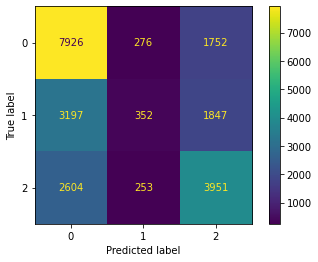

In [24]:
cm_metrics(y_train,y_train_pred,MLPC.classes_)

accuracy:  0.5196967645864357
Recall: 
 {0: 0.7511298583910817, 1: 0.05225125069483046, 2: 0.5517849272807405} 
Precision: 
 {0: 0.5603506405933918, 1: 0.27089337175792505, 2: 0.48321111539945966} 
F1-score: 
 {0: 0.6418640576725025, 1: 0.08760484622553588, 2: 0.5152263374485597}


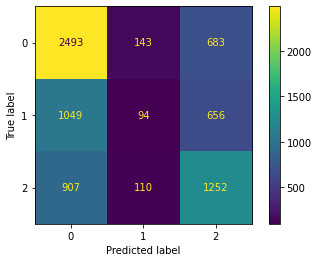

In [25]:
cm_metrics(y_test,y_test_pred,MLPC.classes_)

In [45]:
y.value_counts()

0    13273
2     9077
1     7195
Name: Home_result, dtype: int64

In [46]:
13273/(13273+9077+7195)

0.44924691149094603

In [56]:
MLPC

MLPClassifier(max_iter=500, solver='lbfgs')

In [59]:
pickle.dump(MLPC,open('../data/Model/mlp_classifier1.pkl','wb'))

In [60]:
y_pred = MLPC.predict(X)

accuracy:  0.5385005923168049
Recall: 
 {0: 0.7980863406916296, 1: 0.027102154273801252, 2: 0.5642833535309023} 
Precision: 
 {0: 0.5610996345145399, 1: 0.35583941605839414, 2: 0.506226526981617} 
F1-score: 
 {0: 0.6589325702911171, 1: 0.05036807438977141, 2: 0.533680646001563}


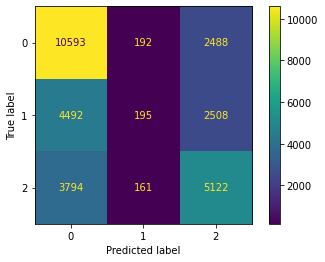

In [61]:
cm_metrics(y,y_pred,MLPC.classes_)

In [62]:
MLPC.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



MLPClassifier(max_iter=500, solver='lbfgs')

accuracy:  0.543205280081232
Recall: 
 {0: 0.8053944097039102, 1: 0.022376650451702573, 2: 0.5726561639308142} 
Precision: 
 {0: 0.5630761127205689, 1: 0.3770491803278688, 2: 0.5129774005723873} 
F1-score: 
 {0: 0.6627813255626512, 1: 0.04224612962477041, 2: 0.5411764705882354}


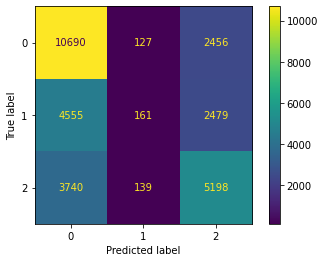

In [64]:
y_pred = MLPC.predict(X)
cm_metrics(y,y_pred,MLPC.classes_)

In [4]:
MLPC = pickle.load(open('../data/Model/mlp_classifier.pkl', 'rb'))

In [5]:
MLPC.predict_proba(X[y==2])[:20]

NameError: name 'X' is not defined